In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

nx = 9
ny = 6

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners 
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# print("mtx: " ,mtx)
# print("dist: " ,dist)

# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

# cv2.imshow('img',undistorted)
# cv2.waitKey(1000)
# print("undistorted")
# cv2.destroyAllWindows()


In [16]:
def corners_unwarp(undistorted_img, mtx, dist):
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    #dst = np.float32([[0,0],[undistorted_img.shape[1]-100,100],[undistorted_img.shape[1]-100,undistorted_img.shape[0]-100],[100,undistorted_img.shape[0]-100]])

    print("img.shape[0]", undistorted_img.shape[0])
    print("img.shape[1]", undistorted_img.shape[1])
#    src  =  np.float32([[undistorted_img.shape[1]//2 - 20, undistorted_img.shape[0]//2], [undistorted_img.shape[1]//2+20, undistorted_img.shape[0]//2], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
#    src  =  np.float32([[600, undistorted_img.shape[0]//2 + 65], [undistorted_img.shape[1]-600, undistorted_img.shape[0]//2+65], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
    src  =  np.float32([[525, undistorted_img.shape[0]//2 + 90],                         [undistorted_img.shape[1] - 525, undistorted_img.shape[0]//2 + 90],                                 [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
    dst  =  np.float32([[0, 0],                                                          [undistorted_img.shape[1], 0],                                 [undistorted_img.shape[1]-280, undistorted_img.shape[0]], [280, undistorted_img.shape[0]]])
#    dst  =  np.float32([[undistorted_img.shape[1]//2 -20, undistorted_img.shape[0]//2], [undistorted_img.shape[1]//2+20, undistorted_img.shape[0]//2], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])    

    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    print("M: ", M)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted_img, M, (undistorted_img.shape[1], undistorted_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M

def hist(img):
    bottom_half = np.sum(img[img.shape[0]//2:,:], axis=0)
    #histogram = sum(bottom_half/255)
    return bottom_half


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # filter out 200 pixels to the left and right, 0:200 and histogram.shape[0]-200:end
    histogram[0:200] = 0
    histogram[histogram.shape[0]-200:] = 0
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    print("nonzero: ", nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    print("nonzerox: ", nonzerox )
    print("nonzeroy: ", nonzeroy )

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    print(binary_warped.shape)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =   leftx_current - margin  # Update this
        win_xleft_high =  leftx_current + margin  # Update this
        
        win_xright_low =  rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin# Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty



def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

def draw_lines(img, undist, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.imshow("color_warp", color_warp)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result
    
    
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    win_x_low_left = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin
    win_x_high_left = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin
    
    win_x_low_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin
    win_x_high_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin
     
    
    good_left_inds =  ((nonzerox >= win_x_low_left) & (nonzerox < win_x_high_left)) 
    good_right_inds = ((nonzerox >= win_x_low_right) & (nonzerox < win_x_high_right)) 
    
    left_lane_inds = good_left_inds
    right_lane_inds = good_right_inds
    
    print("left_lane_inds: ", left_lane_inds)
    print("right_lane_inds: ", right_lane_inds)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    image_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    channel_s = image_hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(channel_s)
    binary[(channel_s > thresh[0]) & (channel_s <= thresh[1])] = 1
    binary_output = binary # placeholder line
    return binary_output


def measure_curvature_real(leftx, rightx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    A_left = left_fit_cr[0]
    A_right = right_fit_cr[0]
    
    B_left = left_fit_cr[1]
    B_right = right_fit_cr[1]
    
    y = y_eval*ym_per_pix
    
    left_curverad = ((1+(2*A_left*y + B_left)**2)**1.5)/ np.absolute(2*A_left)  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*A_right*y+B_right)**2)**1.5)/ np.absolute(2*A_right)  ## Implement the calculation of the right line here
   
#    left_curverad = 0  ## Implement the calculation of the left line here
#    right_curverad = 0  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad



img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
nonzero:  (array([114, 114, 114, ..., 716, 716, 719], dtype=int64), array([517, 518, 519, ..., 412, 413, 795], dtype=int64))
nonzerox:  [517 518 519 ... 412 413 795]
nonzeroy:  [114 114 114 ... 716 716 719]
(720, 1280)
left_fit, right_fit:  [ 1.90683301e-04 -3.90042247e-01  5.93387770e+02] [ 3.09676986e-04 -4.71706714e-01  1.10252779e+03]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  861.5328388344449 530.3251291054365
distance[m]:  2.70595990781461


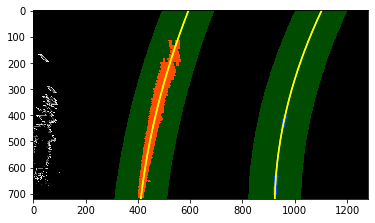

In [10]:
#####################################################
## Images 
####################################################
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/test3.jpg')
undistorted_img = cal_undistort(img, objpoints, imgpoints)
cv2.imshow('img_orig',undistorted_img)
cv2.waitKey(1000)

#rgb = img[...,::-1].copy()
hls_binary = hls_select(undistorted_img, thresh=(70, 255))
hls_binary = hls_binary*255
cv2.imshow('img_binary', hls_binary)
cv2.waitKey(1000)

top_down, perspective_M = corners_unwarp(hls_binary, mtx, dist)
cv2.imshow('img_unwarped',top_down)
cv2.waitKey(1000)

[out_img,  left_fit, right_fit, left_fitx, right_fitx, ploty] = fit_polynomial(top_down)
cv2.imshow("window", out_img)


result = draw_lines( top_down, img, left_fitx, right_fitx, ploty, np.linalg.inv(perspective_M) )
cv2.imshow("plot lines onto image", result)


print("left_fit, right_fit: ", left_fit, right_fit)
[leftx, lefty, rightx, righty, result] = search_around_poly(top_down, left_fit, right_fit)
# View your output
plt.imshow(result)

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
print("left_curverad, right_curverad: ", left_curverad, right_curverad)

# print("left_fitx: ", left_fitx)
# print("ploty: ", ploty)

distance = (right_fitx[-1] - left_fitx[-1])*xm_per_pix
print("distance[m]: ", distance)

In [17]:
#####################################################
## Video 
####################################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

initialized = False
left_fit, right_fit, left_fitx, right_fitx, ploty = None, None, None, None, None

def process_image(image):
    global initialized
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global ploty
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img = image
    undistorted_img = cal_undistort(img, objpoints, imgpoints)

    #rgb = img[...,::-1].copy()
    hls_binary = hls_select(undistorted_img, thresh=(70, 255))
    hls_binary = hls_binary*255

    top_down, perspective_M = corners_unwarp(hls_binary, mtx, dist)

    if not initialized:
        [out_img,  left_fit, right_fit, left_fitx, right_fitx, ploty] = fit_polynomial(top_down)
        result = out_img
        initialized = True
    else:
        [result, left_fitx, right_fitx, ploty] = search_around_poly(top_down, left_fit, right_fit)

    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
    print("left_curverad, right_curverad: ", left_curverad, right_curverad)

    distance = (right_fitx[-1] - left_fitx[-1])*xm_per_pix
    print("distance[m]: ", distance)
    
    result = draw_lines( top_down, img, left_fitx, right_fitx, ploty, np.linalg.inv(perspective_M) )
    return result

In [ ]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(4,5)
#clip1 = VideoFileClip("project_video.mp4").subclip(3,6)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  496.26715839241575 1014.3474295830695
distance[m]:  2.745880958409104


Moviepy - Building video test_videos_output/project_video.mp4.




t:  49%|████████████████▏                | 617/1260 [7:17:43<11:17,  1.05s/it, now=None]

                                                                                        


Moviepy - Writing video test_videos_output/project_video.mp4





t:  49%|████████████████▏                | 617/1260 [7:17:43<11:17,  1.05s/it, now=None]


t:   0%|                                             | 0/1260 [00:00<?, ?it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  496.26715839241575 1014.3474295830695
distance[m]:  2.745880958409104





t:   0%|                                     | 2/1260 [00:01<12:22,  1.69it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  476.8258414537083 637.5883239109082
distance[m]:  2.71710526684374





t:   0%|                                     | 3/1260 [00:02<16:00,  1.31it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  484.8298705661654 637.1116536896768
distance[m]:  2.7096264599098148





t:   0%|                                     | 4/1260 [00:03<19:12,  1.09it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  487.9432275825236 743.6082186824293
distance[m]:  2.707036740284336





t:   0%|▏                                    | 5/1260 [00:04<20:12,  1.04it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  498.04307719892904 578.2661821096108
distance[m]:  2.697925032961922





t:   0%|▏                                    | 6/1260 [00:05<20:56,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  510.14010778977837 648.0306387141909
distance[m]:  2.684990008939071





t:   1%|▏                                    | 7/1260 [00:06<22:02,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  552.4467683948786 468.98062900435036
distance[m]:  2.6758892834119514





t:   1%|▏                                    | 8/1260 [00:08<22:31,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  574.9060593525762 1720.3213900860887
distance[m]:  2.736524938891736





t:   1%|▎                                    | 9/1260 [00:09<22:32,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  595.8011852906839 610.1617010526203
distance[m]:  2.684072287045206





t:   1%|▎                                   | 10/1260 [00:10<22:25,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  561.9595227674141 644.3443174359014
distance[m]:  2.699709106281006





t:   1%|▎                                   | 11/1260 [00:11<22:20,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  575.6956347075094 608.6074565238847
distance[m]:  2.6870308446213853





t:   1%|▎                                   | 12/1260 [00:12<23:00,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  649.8394796895091 823.3232991401978
distance[m]:  2.704881646321571





t:   1%|▎                                   | 13/1260 [00:13<23:01,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  647.0626513300825 1836.9802752531336
distance[m]:  2.723878087631163





t:   1%|▍                                   | 14/1260 [00:14<23:19,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  664.6862332371202 907.3833651576211
distance[m]:  2.698943643114683





t:   1%|▍                                   | 15/1260 [00:15<23:28,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  580.5200859399574 1032.071067339034
distance[m]:  2.6938639208704753





t:   1%|▍                                   | 16/1260 [00:16<23:04,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  563.3271928864395 771.823901778945
distance[m]:  2.6700098565941874





t:   1%|▍                                   | 17/1260 [00:18<22:40,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  531.5168988277062 1016.6386767497793
distance[m]:  2.6781466785209127





t:   1%|▌                                   | 18/1260 [00:19<22:15,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  527.1050754501185 1592.672455970997
distance[m]:  2.6749644392431224





t:   2%|▌                                   | 19/1260 [00:20<22:47,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  529.5014138019151 2364.526531226337
distance[m]:  2.687884498991202





t:   2%|▌                                   | 20/1260 [00:21<22:28,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  541.9950720682507 5625.023144551733
distance[m]:  2.693136579638465





t:   2%|▌                                   | 21/1260 [00:22<22:43,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  551.8077637231377 1546.4164960308683
distance[m]:  2.7329809916200247





t:   2%|▋                                   | 22/1260 [00:23<22:43,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  563.8319083980208 438.0157494326173
distance[m]:  2.7667835783711436





t:   2%|▋                                   | 23/1260 [00:24<22:44,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  629.8840001450241 407.76060189673547
distance[m]:  2.748827495537718





t:   2%|▋                                   | 24/1260 [00:25<22:14,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  536.6449584025785 400.3633215620134
distance[m]:  2.748331984940255





t:   2%|▋                                   | 25/1260 [00:26<21:56,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  510.21150521811126 456.85605933671525
distance[m]:  2.7344828822981944





t:   2%|▋                                   | 26/1260 [00:27<21:34,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  576.533046305444 524.9564028575124
distance[m]:  2.6999604751433868





t:   2%|▊                                   | 27/1260 [00:28<21:30,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  521.4392835218084 634.837219666064
distance[m]:  2.732446240059519





t:   2%|▊                                   | 28/1260 [00:29<21:19,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  504.83871220007956 570.4784749767199
distance[m]:  2.751306762170075





t:   2%|▊                                   | 29/1260 [00:30<21:50,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  479.208521476389 555.9309727530788
distance[m]:  2.754308569912992





t:   2%|▊                                   | 30/1260 [00:31<21:34,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  420.0578666220815 550.4215503556223
distance[m]:  2.7607220700816386





t:   2%|▉                                   | 31/1260 [00:32<21:18,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  410.41388276706175 761.21392441819
distance[m]:  2.760970195569567





t:   3%|▉                                   | 32/1260 [00:33<21:20,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  384.38710418804413 776.8066433110058
distance[m]:  2.747877365089792





t:   3%|▉                                   | 33/1260 [00:35<22:32,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  400.7556690047604 544.6825305460012
distance[m]:  2.759144399489171





t:   3%|▉                                   | 34/1260 [00:36<22:17,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  370.0691026699655 32043.093637704293
distance[m]:  2.8194307274267167





t:   3%|█                                   | 35/1260 [00:37<22:32,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  367.9191774628509 587.615821140824
distance[m]:  2.7626954130799497





t:   3%|█                                   | 36/1260 [00:38<21:54,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  365.48002031312836 570.0662661269579
distance[m]:  2.750532778910055





t:   3%|█                                   | 37/1260 [00:39<22:05,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  367.44759230644877 642.4085887404667
distance[m]:  2.739910733024224





t:   3%|█                                   | 38/1260 [00:40<21:48,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  359.939909317207 683.0824269023136
distance[m]:  2.7299574578566563





t:   3%|█                                   | 39/1260 [00:41<22:19,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  345.5737095371671 687.6853066930664
distance[m]:  2.716972131024642





t:   3%|█▏                                  | 40/1260 [00:42<21:48,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  359.4734693197519 565.2518440551274
distance[m]:  2.7013156888487857





t:   3%|█▏                                  | 41/1260 [00:44<23:08,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  366.6383494770863 710.9580097447318
distance[m]:  2.6987273508292327





t:   3%|█▏                                  | 42/1260 [00:45<23:44,  1.17s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  381.117710961707 756.3589095425235
distance[m]:  2.6873874626574223





t:   3%|█▏                                  | 43/1260 [00:46<22:45,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  395.1043991553957 513.6354606207574
distance[m]:  2.682092009529913





t:   3%|█▎                                  | 44/1260 [00:47<22:21,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  438.5428680879876 573.992655224187
distance[m]:  2.6771525350211753





t:   4%|█▎                                  | 45/1260 [00:48<24:26,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  460.87108428735746 534.5106279554738
distance[m]:  2.6777665376343536





t:   4%|█▎                                  | 46/1260 [00:50<25:43,  1.27s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  462.60813017618426 3231.8719238820286
distance[m]:  2.754239188553988





t:   4%|█▎                                  | 47/1260 [00:51<24:39,  1.22s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  489.66638401877736 2686.3971730056332
distance[m]:  2.7413535014545314





t:   4%|█▎                                  | 48/1260 [00:52<24:45,  1.23s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  500.1623692642005 939.7230465756653
distance[m]:  2.7241997444444204





t:   4%|█▍                                  | 49/1260 [00:53<25:49,  1.28s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  535.1476027626674 529.5898100455131
distance[m]:  2.723333499113205





t:   4%|█▍                                  | 50/1260 [00:55<26:45,  1.33s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  559.684453307403 1471.8922643680567
distance[m]:  2.7046963789884253





t:   4%|█▍                                  | 51/1260 [00:56<26:19,  1.31s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  577.5605000727194 513.9511047586593
distance[m]:  2.677832151971996





t:   4%|█▍                                  | 52/1260 [00:57<24:48,  1.23s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  570.2149672485483 441.3521128014177
distance[m]:  2.662320892467945





t:   4%|█▌                                  | 53/1260 [00:58<23:59,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  557.2885477886151 540.8089049941599
distance[m]:  2.667074507483399





t:   4%|█▌                                  | 54/1260 [01:00<24:24,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  584.0617419740179 539.4179147304947
distance[m]:  2.663524201570303





t:   4%|█▌                                  | 55/1260 [01:01<24:18,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  615.271971961847 525.3350878867961
distance[m]:  2.6700173407325605





t:   4%|█▌                                  | 56/1260 [01:02<24:16,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  609.1254722337039 569.0072699366891
distance[m]:  2.6783794530008





t:   5%|█▋                                  | 57/1260 [01:04<26:32,  1.32s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  611.4759513611866 541.2885290666287
distance[m]:  2.6830164188734487





t:   5%|█▋                                  | 58/1260 [01:05<24:54,  1.24s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  605.5669903614984 411.5083234141789
distance[m]:  2.6868667713079186





t:   5%|█▋                                  | 59/1260 [01:06<23:50,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  555.4044547362246 10484.600629423145
distance[m]:  2.74208999077185





t:   5%|█▋                                  | 60/1260 [01:07<25:53,  1.29s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  525.4520228604965 6230.025298886567
distance[m]:  2.7196397384123894





t:   5%|█▋                                  | 61/1260 [01:08<24:56,  1.25s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  532.8604385266308 684.6289730246098
distance[m]:  2.7061551223064786





t:   5%|█▊                                  | 62/1260 [01:09<24:03,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  502.50796436628826 770.4646281683146
distance[m]:  2.70596679296687





t:   5%|█▊                                  | 63/1260 [01:11<23:14,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  515.9610237028087 958.6051882556106
distance[m]:  2.710093665152155





t:   5%|█▊                                  | 64/1260 [01:12<22:38,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  481.36787160740516 798.6684670070406
distance[m]:  2.703545818944673





t:   5%|█▊                                  | 65/1260 [01:13<21:59,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  549.543034004446 756.9528374100233
distance[m]:  2.689969218578648





t:   5%|█▉                                  | 66/1260 [01:14<22:06,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  519.3280518001229 751.2287519593641
distance[m]:  2.6860113100824328





t:   5%|█▉                                  | 67/1260 [01:15<25:21,  1.28s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  532.3026463512284 824.7097162508793
distance[m]:  2.6825254222088644





t:   5%|█▉                                  | 68/1260 [01:17<26:56,  1.36s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  526.9934532927554 3153.1071916348983
distance[m]:  2.69541372782308





t:   5%|█▉                                  | 69/1260 [01:18<25:52,  1.30s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  522.6143065242395 4954.211791582607
distance[m]:  2.6845324412486256





t:   6%|██                                  | 70/1260 [01:19<25:30,  1.29s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  565.4697923986598 2679.241874994952
distance[m]:  2.6830921627209188





t:   6%|██                                  | 71/1260 [01:21<24:44,  1.25s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  546.1052920421633 834.5407613583728
distance[m]:  2.754176981792135





t:   6%|██                                  | 72/1260 [01:22<25:09,  1.27s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  589.4245597542048 852.1591641773709
distance[m]:  2.6925097280143615





t:   6%|██                                  | 73/1260 [01:23<25:53,  1.31s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  612.4815974469442 956.0794411379142
distance[m]:  2.6884632499966132





t:   6%|██                                  | 74/1260 [01:24<24:39,  1.25s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  623.558602053722 1212.8882478308085
distance[m]:  2.6895315626493526





t:   6%|██▏                                 | 75/1260 [01:25<23:20,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  661.4346112608972 1501.7522765089818
distance[m]:  2.692870100353434





t:   6%|██▏                                 | 76/1260 [01:26<22:22,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  647.7562967738033 659.5725858860466
distance[m]:  2.658460308259384





t:   6%|██▏                                 | 77/1260 [01:28<22:19,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  738.4900863731538 716.6845628848383
distance[m]:  2.670644202832036





t:   6%|██▏                                 | 78/1260 [01:29<21:35,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  739.4204901676535 863.3227696526832
distance[m]:  2.6891956673488533





t:   6%|██▎                                 | 79/1260 [01:30<21:07,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  744.2488335829477 1071.5870296694252
distance[m]:  2.698282846732125





t:   6%|██▎                                 | 80/1260 [01:31<20:57,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  730.8952899450294 1024.5880468282037
distance[m]:  2.7024156577180194





t:   6%|██▎                                 | 81/1260 [01:32<20:42,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  662.0503595201857 2067.014730322637
distance[m]:  2.7119482051682304





t:   7%|██▎                                 | 82/1260 [01:33<20:27,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  659.138429944433 649.4294904396835
distance[m]:  2.7131405525026033





t:   7%|██▎                                 | 83/1260 [01:34<20:11,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  647.5502752255309 601.5627099360341
distance[m]:  2.728457586299356





t:   7%|██▍                                 | 84/1260 [01:35<20:02,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  683.3400350456658 2307.118218856509
distance[m]:  2.814851018553659





t:   7%|██▍                                 | 85/1260 [01:36<19:54,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  642.7945078957375 837.8964634357409
distance[m]:  2.8229623274355338





t:   7%|██▍                                 | 86/1260 [01:37<19:56,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  603.7356650988219 650.499938303477
distance[m]:  2.787523048364986





t:   7%|██▍                                 | 87/1260 [01:38<19:57,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  577.490198003362 717.169249198285
distance[m]:  2.7766438015630444





t:   7%|██▌                                 | 88/1260 [01:39<20:27,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  512.2897343765497 925.0434515578933
distance[m]:  2.779220339936802





t:   7%|██▌                                 | 89/1260 [01:40<20:20,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  464.6199670298926 807.6566706482292
distance[m]:  2.7650780807074677





t:   7%|██▌                                 | 90/1260 [01:41<20:27,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  418.00796222373833 514.2182052736671
distance[m]:  2.7331195929699486





t:   7%|██▌                                 | 91/1260 [01:42<20:19,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  444.7633648885024 834.7990457761958
distance[m]:  2.7410023845308746





t:   7%|██▋                                 | 92/1260 [01:43<21:39,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  445.8642585936583 1063.7997823636701
distance[m]:  2.7387676366259877





t:   7%|██▋                                 | 93/1260 [01:44<22:12,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  425.66896854135496 1351.8272911734623
distance[m]:  2.730877980753618





t:   7%|██▋                                 | 94/1260 [01:45<21:21,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  418.6196028873309 659.4341045240661
distance[m]:  2.71658399382896





t:   8%|██▋                                 | 95/1260 [01:46<20:49,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  430.44161838381285 625.3308548271683
distance[m]:  2.710649606911767





t:   8%|██▋                                 | 96/1260 [01:48<20:33,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  437.29816708193727 682.3806169900848
distance[m]:  2.7159916840189506





t:   8%|██▊                                 | 97/1260 [01:49<20:36,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  438.16138138043283 776.0338964635827
distance[m]:  2.7139243251886835





t:   8%|██▊                                 | 98/1260 [01:50<20:16,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  462.2804231444586 869.7867342850735
distance[m]:  2.7168022239468073





t:   8%|██▊                                 | 99/1260 [01:51<20:09,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  438.1412572654004 701.266269926103
distance[m]:  2.698241377402848





t:   8%|██▊                                | 100/1260 [01:52<19:54,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  450.60089113492285 666.1791535846128
distance[m]:  2.6900784709787406





t:   8%|██▊                                | 101/1260 [01:53<19:49,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  454.7860638003696 512.7496089574759
distance[m]:  2.6625506581390437





t:   8%|██▊                                | 102/1260 [01:54<19:49,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  428.29219400361325 505.3917896422984
distance[m]:  2.658082616010628





t:   8%|██▊                                | 103/1260 [01:55<19:46,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  416.6750179617106 474.4248420255295
distance[m]:  2.6612233808464802





t:   8%|██▉                                | 104/1260 [01:56<19:43,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  416.7799444804826 561.7281921430089
distance[m]:  2.6680687029136045





t:   8%|██▉                                | 105/1260 [01:57<20:19,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  435.30393674880327 571.4535758091675
distance[m]:  2.6801047258408506





t:   8%|██▉                                | 106/1260 [01:58<20:12,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  439.9364345552049 740.7249507070148
distance[m]:  2.693507459043925





t:   8%|██▉                                | 107/1260 [01:59<20:26,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  447.54741755656244 669.7408917837987
distance[m]:  2.7030261899946715





t:   9%|███                                | 108/1260 [02:00<21:45,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  418.7102678352814 405.0144539476021
distance[m]:  2.6984017162176497





t:   9%|███                                | 109/1260 [02:01<21:50,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  418.9994237570739 1151.636353010575
distance[m]:  2.753809524400086





t:   9%|███                                | 110/1260 [02:03<22:39,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  418.1267877947453 4487.291472533171
distance[m]:  2.760266830193153





t:   9%|███                                | 111/1260 [02:04<22:36,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  399.14335760638374 707.5100338181174
distance[m]:  2.730569434924135





t:   9%|███                                | 112/1260 [02:05<21:56,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  457.24983468315787 805.6881723333887
distance[m]:  2.7314579775339367





t:   9%|███▏                               | 113/1260 [02:06<24:03,  1.26s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  435.80183315685684 941.2978434775578
distance[m]:  2.72807674647713





t:   9%|███▏                               | 114/1260 [02:08<23:11,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  433.0436197197629 813.0734368282074
distance[m]:  2.716207501314794





t:   9%|███▏                               | 115/1260 [02:09<22:48,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  390.57915645780054 1184.5254796714696
distance[m]:  2.720544245995405





t:   9%|███▏                               | 116/1260 [02:10<22:31,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  391.05135691388523 1341.1107910681
distance[m]:  2.707675619885043





t:   9%|███▎                               | 117/1260 [02:11<22:12,  1.17s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  412.5444558198473 1003.5874088840889
distance[m]:  2.694427572170848





t:   9%|███▎                               | 118/1260 [02:12<23:02,  1.21s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  386.23774543935076 929.3588634966421
distance[m]:  2.6934864428804084





t:   9%|███▎                               | 119/1260 [02:14<23:11,  1.22s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  393.27515135821966 787.2713514869532
distance[m]:  2.684919172831674





t:  10%|███▎                               | 120/1260 [02:15<22:03,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  387.40011011055896 419.5660384229879
distance[m]:  2.6691924526085447





t:  10%|███▎                               | 121/1260 [02:16<21:14,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  397.18229650729234 494.5611343901804
distance[m]:  2.6745327668541528





t:  10%|███▍                               | 122/1260 [02:17<21:03,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  400.791077599885 3134.838583158231
distance[m]:  2.727359059108638





t:  10%|███▍                               | 123/1260 [02:18<21:58,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  394.3216341667841 466.6896651052754
distance[m]:  2.6769399460005303





t:  10%|███▍                               | 124/1260 [02:19<22:19,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  411.43279484618694 463.92529774894126
distance[m]:  2.6619095221825093





t:  10%|███▍                               | 125/1260 [02:20<21:21,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  416.716524015202 518.2519568110436
distance[m]:  2.664932935740711





t:  10%|███▌                               | 126/1260 [02:22<22:21,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  442.14646355668634 390.9057175438265
distance[m]:  2.644763152905295





t:  10%|███▌                               | 127/1260 [02:23<23:27,  1.24s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  442.15881737946467 432.74200664190806
distance[m]:  2.6552241703310027





t:  10%|███▌                               | 128/1260 [02:24<23:35,  1.25s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  465.12484417007477 386.7605893640114
distance[m]:  2.6484428662030073





t:  10%|███▌                               | 129/1260 [02:26<24:35,  1.30s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  442.15811669759375 420.8578768011647
distance[m]:  2.6415827372883594





t:  10%|███▌                               | 130/1260 [02:27<25:43,  1.37s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  446.9926605800487 467.04815678270177
distance[m]:  2.6481556388191057





t:  10%|███▋                               | 131/1260 [02:28<23:48,  1.27s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  441.743372034753 461.64338206772294
distance[m]:  2.6516413567112287





t:  10%|███▋                               | 132/1260 [02:29<22:24,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  453.86429434998666 498.4754194498963
distance[m]:  2.6419803431293967





t:  11%|███▋                               | 133/1260 [02:30<21:31,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  487.15635200000474 556.9199743827655
distance[m]:  2.6429331997868792





t:  11%|███▋                               | 134/1260 [02:31<21:28,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  485.79356992749143 6694.9451000716945
distance[m]:  2.7043176760314562





t:  11%|███▊                               | 135/1260 [02:32<20:45,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  496.42790853678963 9951.399199279409
distance[m]:  2.6903819559526463





t:  11%|███▊                               | 136/1260 [02:33<20:14,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  497.1554443532979 958.5591722472698
distance[m]:  2.6639005687952926





t:  11%|███▊                               | 137/1260 [02:34<20:08,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  517.8338347535094 4558.627573686046
distance[m]:  2.6911682244202626





t:  11%|███▊                               | 138/1260 [02:36<20:15,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  544.4651203526034 607.8688470497813
distance[m]:  2.6777649900768368





t:  11%|███▊                               | 139/1260 [02:37<20:18,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  599.4224489359914 545.589247997358
distance[m]:  2.670430457714431





t:  11%|███▉                               | 140/1260 [02:38<19:58,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  634.412152200673 689.2076946001705
distance[m]:  2.6890058186996173





t:  11%|███▉                               | 141/1260 [02:39<19:52,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  594.5227365647208 799.1381415825782
distance[m]:  2.699347851621314





t:  11%|███▉                               | 142/1260 [02:41<24:29,  1.31s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  591.6235178786458 1023.9279752659914
distance[m]:  2.7030820538239837





t:  11%|███▉                               | 143/1260 [02:42<24:19,  1.31s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  539.7957552170022 707.2557266536743
distance[m]:  2.6970059448009778





t:  11%|████                               | 144/1260 [02:43<23:20,  1.26s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  513.9678063521931 749.2129288976154
distance[m]:  2.6952327220410988





t:  12%|████                               | 145/1260 [02:44<23:01,  1.24s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  521.4256917822431 541.4860261755505
distance[m]:  2.697054004185331





t:  12%|████                               | 146/1260 [02:45<22:01,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  507.46912500233213 611.6312372112844
distance[m]:  2.6965428365755155





t:  12%|████                               | 147/1260 [02:46<21:25,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  546.0328485374565 4100.910755442347
distance[m]:  2.7669324279840346





t:  12%|████                               | 148/1260 [02:48<26:00,  1.40s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  468.1895811852452 2536.5497050563094
distance[m]:  2.730713591974733





t:  12%|████▏                              | 149/1260 [02:50<26:53,  1.45s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  440.3663872151209 608.2833428562951
distance[m]:  2.7550146071727597





t:  12%|████▏                              | 150/1260 [02:51<25:01,  1.35s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  473.4609722826574 1342.385437402445
distance[m]:  2.728342466971496





t:  12%|████▏                              | 151/1260 [02:52<23:47,  1.29s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  521.9376236850804 1601.1070393898274
distance[m]:  2.7131283747057466





t:  12%|████▏                              | 152/1260 [02:54<24:01,  1.30s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  523.780428845443 1104.964110095879
distance[m]:  2.7036371813365254





t:  12%|████▎                              | 153/1260 [02:55<23:32,  1.28s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  486.3417790749113 1444.6037819293374
distance[m]:  2.7004076894455835





t:  12%|████▎                              | 154/1260 [02:56<21:54,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  507.15471701471233 1372.3562625922534
distance[m]:  2.7058508409522335





t:  12%|████▎                              | 155/1260 [02:57<20:59,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  524.4041637297526 1287.3835997216224
distance[m]:  2.70968384425393





t:  12%|████▎                              | 156/1260 [02:58<20:23,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  522.8436069484103 1020.1840861332886
distance[m]:  2.704598665109695





t:  12%|████▎                              | 157/1260 [02:59<19:58,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  516.3220747383373 754.6831389032119
distance[m]:  2.7031297696736964





t:  13%|████▍                              | 158/1260 [03:00<19:36,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  491.9762987943393 523.225671276129
distance[m]:  2.687776931996711





t:  13%|████▍                              | 159/1260 [03:01<19:23,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  491.8565285838809 428.39758558520134
distance[m]:  2.8477972156541194





t:  13%|████▍                              | 160/1260 [03:02<20:42,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  474.1774675299537 857.2115850008325
distance[m]:  2.7269961428981544





t:  13%|████▍                              | 161/1260 [03:03<20:15,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  493.05930767859707 3894.5156829463417
distance[m]:  2.740994410978873





t:  13%|████▌                              | 162/1260 [03:04<19:39,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  495.9227367849979 1852.1942433743898
distance[m]:  2.7496270882727587





t:  13%|████▌                              | 163/1260 [03:05<19:43,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  526.5583322132411 591.6124834139872
distance[m]:  2.7304092849260067





t:  13%|████▌                              | 164/1260 [03:06<19:06,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  482.10094914460245 581.7285451926405
distance[m]:  2.7310655529437415





t:  13%|████▌                              | 165/1260 [03:07<18:45,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  460.41644558303665 502.557152929217
distance[m]:  2.7157700425638





t:  13%|████▌                              | 166/1260 [03:08<18:28,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  457.9347688865388 914.5802676932932
distance[m]:  2.7295631459653245





t:  13%|████▋                              | 167/1260 [03:09<18:15,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  414.51566827650873 1184.504822687444
distance[m]:  2.733111070565158





t:  13%|████▋                              | 168/1260 [03:10<18:05,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  467.5969037158945 1009.7297924776293
distance[m]:  2.7288048093748536





t:  13%|████▋                              | 169/1260 [03:11<17:56,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  461.22355241892967 1977.506888225873
distance[m]:  2.7389861083356064





t:  13%|████▋                              | 170/1260 [03:12<17:54,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  511.0509332001185 3945.11635214818
distance[m]:  2.7382625232253077





t:  14%|████▊                              | 171/1260 [03:13<17:53,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  488.35414805275667 8344.257088398603
distance[m]:  2.7377241181457346





t:  14%|████▊                              | 172/1260 [03:14<18:44,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  487.9030838642362 1389.5741857188918
distance[m]:  2.764681384057061





t:  14%|████▊                              | 173/1260 [03:15<18:35,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  453.6480799097045 580.2136942920048
distance[m]:  2.7728718893097666





t:  14%|████▊                              | 174/1260 [03:16<18:24,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  415.9975661668995 394.8431110073227
distance[m]:  2.7677034416253483





t:  14%|████▊                              | 175/1260 [03:17<18:13,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  395.7568999020625 841.1632216314221
distance[m]:  2.7375892708692966





t:  14%|████▉                              | 176/1260 [03:18<18:12,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  377.3415630670128 464.4210128362459
distance[m]:  2.7108939299778188





t:  14%|████▉                              | 177/1260 [03:19<18:17,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  429.45390278925174 447.7927366469814
distance[m]:  2.7083434683787524





t:  14%|████▉                              | 178/1260 [03:20<18:12,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  427.4844673878591 414.33150357844846
distance[m]:  2.721237086929347





t:  14%|████▉                              | 179/1260 [03:21<18:06,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  420.9705667966218 431.12270194190995
distance[m]:  2.735410600451786





t:  14%|█████                              | 180/1260 [03:22<18:03,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  408.25804814096045 501.952048554514
distance[m]:  2.7612859419078193





t:  14%|█████                              | 181/1260 [03:23<18:09,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  379.15158653061593 317.1223947685589
distance[m]:  2.760749907586172





t:  14%|█████                              | 182/1260 [03:24<18:16,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  396.445003003593 314.950668575437
distance[m]:  2.7725744512657786





t:  15%|█████                              | 183/1260 [03:25<18:32,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  368.7994708771293 313.4299674624509
distance[m]:  2.778632436393151





t:  15%|█████                              | 184/1260 [03:26<18:17,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  347.571816910698 482.34848281827396
distance[m]:  2.8208360097667264





t:  15%|█████▏                             | 185/1260 [03:28<18:55,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  338.15535068599974 638.5513003790882
distance[m]:  2.814072268792673





t:  15%|█████▏                             | 186/1260 [03:29<18:37,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  313.17108523762516 3669.263147003437
distance[m]:  2.8073172967874847





t:  15%|█████▏                             | 187/1260 [03:30<18:28,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  310.9318932621688 652.3582478177395
distance[m]:  2.7865792893087926





t:  15%|█████▏                             | 188/1260 [03:31<18:16,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  301.46175708876547 10420.171443708268
distance[m]:  2.791531144602728





t:  15%|█████▎                             | 189/1260 [03:32<18:14,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  308.12487724953326 215.20020339470406
distance[m]:  2.726175675817905





t:  15%|█████▎                             | 190/1260 [03:33<18:04,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  309.06763511404876 293.4677461835348
distance[m]:  2.735710809642909





t:  15%|█████▎                             | 191/1260 [03:34<17:57,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  306.4521780435186 345.76176196119087
distance[m]:  2.726165873955572





t:  15%|█████▎                             | 192/1260 [03:35<17:55,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  318.2824149570516 353.1950996828738
distance[m]:  2.7230056805184053





t:  15%|█████▎                             | 193/1260 [03:36<18:19,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  314.45737246005893 422.5713772689082
distance[m]:  2.7146079463290724





t:  15%|█████▍                             | 194/1260 [03:37<18:18,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  323.5698565550613 641.0700804944555
distance[m]:  2.7078092456166454





t:  15%|█████▍                             | 195/1260 [03:38<18:01,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  325.01774805074257 401.37736043920586
distance[m]:  2.7051362378366206





t:  16%|█████▍                             | 196/1260 [03:39<17:50,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  369.539077481393 413.0518228423181
distance[m]:  2.6876951559677984





t:  16%|█████▍                             | 197/1260 [03:40<17:45,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  430.8087658225811 5423.631913159078
distance[m]:  2.7782193587931565





t:  16%|█████▌                             | 198/1260 [03:41<17:40,  1.00it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  515.428303049514 3404.0611078459906
distance[m]:  2.769005502921761





t:  16%|█████▌                             | 199/1260 [03:42<17:47,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  568.0032661691183 3267.9384640956646
distance[m]:  2.781468292344648





t:  16%|█████▌                             | 200/1260 [03:43<18:53,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  558.0806610669293 601.0289876493017
distance[m]:  2.7589619327126536





t:  16%|█████▌                             | 201/1260 [03:44<18:39,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  568.1788310722701 809.9068518378937
distance[m]:  2.7795223454785063





t:  16%|█████▌                             | 202/1260 [03:45<18:46,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  534.347917638911 744.1725250330911
distance[m]:  2.7718143597564997





t:  16%|█████▋                             | 203/1260 [03:46<18:16,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  497.9048460424078 804.092619407191
distance[m]:  2.7741994257420686





t:  16%|█████▋                             | 204/1260 [03:47<17:55,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  493.5261544722512 757.1840457226058
distance[m]:  2.7738493834401123





t:  16%|█████▋                             | 205/1260 [03:48<17:45,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  454.3013961025214 635.9285222834937
distance[m]:  2.762175033479559





t:  16%|█████▋                             | 206/1260 [03:49<17:35,  1.00s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  428.017300658871 595.1852307045472
distance[m]:  2.759598955083868





t:  16%|█████▊                             | 207/1260 [03:50<17:32,  1.00it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  390.01609030966085 580.5417017876504
distance[m]:  2.7465648807881236





t:  17%|█████▊                             | 208/1260 [03:51<17:26,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  373.8723957104254 444.5393476100599
distance[m]:  2.7394172193031627





t:  17%|█████▊                             | 209/1260 [03:52<17:21,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  398.24674581128176 785.2604555145258
distance[m]:  2.765436415365447





t:  17%|█████▊                             | 210/1260 [03:53<17:15,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  412.0872408198903 9151.46955585307
distance[m]:  2.792277863247255





t:  17%|█████▊                             | 211/1260 [03:54<17:12,  1.02it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  470.9044795870345 564.5333081919844
distance[m]:  2.7645565868958166





t:  17%|█████▉                             | 212/1260 [03:55<17:21,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  463.14091836918976 626.9209952832529
distance[m]:  2.766025190153042





t:  17%|█████▉                             | 213/1260 [03:56<18:01,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  470.4421384539966 701.8909718097749
distance[m]:  2.7616090632196904





t:  17%|█████▉                             | 214/1260 [03:57<17:45,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  443.37576707797524 500.1789285997653
distance[m]:  2.7436536481304876





t:  17%|█████▉                             | 215/1260 [03:58<17:35,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  455.0327458818899 591.2977755892489
distance[m]:  2.7384537833410585





t:  17%|██████                             | 216/1260 [03:59<17:59,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  454.6328755946736 484.99406184113485
distance[m]:  2.7274107984624987





t:  17%|██████                             | 217/1260 [04:00<17:50,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  449.3904581609062 529.1519344354666
distance[m]:  2.7230663110205184





t:  17%|██████                             | 218/1260 [04:01<19:12,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  476.83637742941056 399.00094205670655
distance[m]:  2.714279927681585





t:  17%|██████                             | 219/1260 [04:03<20:37,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  457.48982067538304 406.2823945521949
distance[m]:  2.7051580894074556





t:  17%|██████                             | 220/1260 [04:04<20:48,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  504.28004939986914 375.8112982433399
distance[m]:  2.7024832724594074





t:  18%|██████▏                            | 221/1260 [04:05<20:50,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  524.414347177819 393.39051255813024
distance[m]:  2.710795274054834





t:  18%|██████▏                            | 222/1260 [04:07<21:28,  1.24s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  542.2700357401507 434.17662104880174
distance[m]:  2.7098771074625105





t:  18%|██████▏                            | 223/1260 [04:08<21:08,  1.22s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  553.350673667247 887.6516990899596
distance[m]:  2.7266849449760087





t:  18%|██████▏                            | 224/1260 [04:09<20:45,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  515.7805917658025 1394.1040914823686
distance[m]:  2.7325903761196186





t:  18%|██████▎                            | 225/1260 [04:11<24:18,  1.41s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  540.158523891281 4503.692329860433
distance[m]:  2.7408189722374927





t:  18%|██████▎                            | 226/1260 [04:12<24:23,  1.42s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  508.6356715417851 2549.2835934037234
distance[m]:  2.722334067300599





t:  18%|██████▎                            | 227/1260 [04:14<24:41,  1.43s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  525.6153803618013 3148.4954199502026
distance[m]:  2.712842107223225





t:  18%|██████▎                            | 228/1260 [04:15<23:32,  1.37s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  552.0616849048686 3842.835744269853
distance[m]:  2.704835099715272





t:  18%|██████▎                            | 229/1260 [04:16<22:34,  1.31s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  535.1665827087227 8749.019277731031
distance[m]:  2.70267025529479





t:  18%|██████▍                            | 230/1260 [04:18<24:38,  1.44s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  561.2089135904436 7364.138081618864
distance[m]:  2.7039958271073785





t:  18%|██████▍                            | 231/1260 [04:19<23:55,  1.39s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  567.1293585116821 1445.8357167421188
distance[m]:  2.6887363328150338





t:  18%|██████▍                            | 232/1260 [04:20<23:18,  1.36s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  583.0503925585808 684.0217691622464
distance[m]:  2.68916731286851





t:  18%|██████▍                            | 233/1260 [04:21<22:10,  1.30s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  587.9183270223878 3853.3022510837845
distance[m]:  2.7488173628670345





t:  19%|██████▌                            | 234/1260 [04:23<21:03,  1.23s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  595.4413324203024 785.3825482108641
distance[m]:  2.7124579711523906





t:  19%|██████▌                            | 235/1260 [04:24<22:06,  1.29s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  553.9171033818451 664.4392133143957
distance[m]:  2.7163650433514888





t:  19%|██████▌                            | 236/1260 [04:25<22:58,  1.35s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  510.6606709620495 622.9256807956688
distance[m]:  2.701709725914405





t:  19%|██████▌                            | 237/1260 [04:27<21:32,  1.26s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  493.4221422349039 412.826513109944
distance[m]:  2.6850758621327344





t:  19%|██████▌                            | 238/1260 [04:28<20:56,  1.23s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  470.45657798696874 547.5458420155286
distance[m]:  2.7087461858558743





t:  19%|██████▋                            | 239/1260 [04:29<20:21,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  451.9585703504422 594.9741061446282
distance[m]:  2.7148306761611365





t:  19%|██████▋                            | 240/1260 [04:30<21:21,  1.26s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  455.34595802398076 600.9225408626523
distance[m]:  2.718951947940362





t:  19%|██████▋                            | 241/1260 [04:32<21:47,  1.28s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  446.9328806517959 686.4058010537569
distance[m]:  2.7169474808827454





t:  19%|██████▋                            | 242/1260 [04:33<21:06,  1.24s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  482.69109053637095 622.7781448523909
distance[m]:  2.7272262042877276





t:  19%|██████▊                            | 243/1260 [04:34<20:18,  1.20s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  448.9039052863424 644.2995048476832
distance[m]:  2.7233716584095826





t:  19%|██████▊                            | 244/1260 [04:35<19:21,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  454.92833448555655 570.3567079073069
distance[m]:  2.722436371362504





t:  19%|██████▊                            | 245/1260 [04:36<19:13,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  438.7957786061442 484.79038045250564
distance[m]:  2.72647354754417





t:  20%|██████▊                            | 246/1260 [04:37<19:11,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  433.71095361749065 913.7086950921016
distance[m]:  2.7496336637310144





t:  20%|██████▊                            | 247/1260 [04:38<18:50,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  439.1890304957335 521.5577853818214
distance[m]:  2.7440205068930617





t:  20%|██████▉                            | 248/1260 [04:39<18:34,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  413.7604286870909 504.05258014244595
distance[m]:  2.7336572580448495





t:  20%|██████▉                            | 249/1260 [04:40<18:14,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  430.2098712981963 514.6268578910203
distance[m]:  2.7352233669754953





t:  20%|██████▉                            | 250/1260 [04:41<18:26,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  421.7015425000316 455.53837134961606
distance[m]:  2.723190982171155





t:  20%|██████▉                            | 251/1260 [04:43<18:58,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  472.06657347719573 685.5825165325437
distance[m]:  2.7368184408378413





t:  20%|███████                            | 252/1260 [04:44<18:51,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  475.9503525714511 538.1138318449392
distance[m]:  2.726252859510015





t:  20%|███████                            | 253/1260 [04:45<18:34,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  470.3684411734255 579.5050977107677
distance[m]:  2.7270434831323254





t:  20%|███████                            | 254/1260 [04:46<19:21,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  497.25073325640295 580.862691860565
distance[m]:  2.728573005047777





t:  20%|███████                            | 255/1260 [04:47<19:05,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  468.9333854820266 484.1834951629344
distance[m]:  2.724237766414988





t:  20%|███████                            | 256/1260 [04:48<19:02,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  507.5780539911995 538.9921428142567
distance[m]:  2.718262383818455





t:  20%|███████▏                           | 257/1260 [04:49<18:54,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  491.8565979893574 19148.966573709775
distance[m]:  2.7907782095135047





t:  20%|███████▏                           | 258/1260 [04:50<18:45,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  500.385894361828 1841.8404147382555
distance[m]:  2.7709740517813386





t:  21%|███████▏                           | 259/1260 [04:52<19:12,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  511.87951588650674 1582.3529670260107
distance[m]:  2.7494560876771863





t:  21%|███████▏                           | 260/1260 [04:53<19:42,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  491.4692248299177 757.055424023211
distance[m]:  2.7390030940066508





t:  21%|███████▎                           | 261/1260 [04:54<18:55,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  564.9462872347816 834.9854274501068
distance[m]:  2.7407000432605635





t:  21%|███████▎                           | 262/1260 [04:55<18:35,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  560.6480148414853 568.1961620897174
distance[m]:  2.715789342207381





t:  21%|███████▎                           | 263/1260 [04:56<18:17,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  538.9153208668058 722.2357883642042
distance[m]:  2.7304401202165582





t:  21%|███████▎                           | 264/1260 [04:58<22:01,  1.33s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  546.1627786211732 670.1575276609867
distance[m]:  2.7303389042078203





t:  21%|███████▎                           | 265/1260 [05:00<23:47,  1.43s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  575.7848836670844 730.4917559781471
distance[m]:  2.7286372163706893





t:  21%|███████▍                           | 266/1260 [05:01<23:18,  1.41s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  548.4113161803717 743.0814875359761
distance[m]:  2.7458041357720155





t:  21%|███████▍                           | 267/1260 [05:04<29:45,  1.80s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  545.974082646412 577.5159048699282
distance[m]:  2.7384775518402815





t:  21%|███████▍                           | 268/1260 [05:05<28:16,  1.71s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  563.7238222304659 470.6937095479569
distance[m]:  2.7381190753483873





t:  21%|███████▍                           | 269/1260 [05:07<26:47,  1.62s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  603.4078239984126 499.203998999614
distance[m]:  2.7458964324486734





t:  21%|███████▌                           | 270/1260 [05:08<24:38,  1.49s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  606.7242625563633 361.5585104832922
distance[m]:  2.7367237004989797





t:  22%|███████▌                           | 271/1260 [05:09<23:59,  1.46s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  626.3552120203185 929.3149562776563
distance[m]:  2.7948682295589338





t:  22%|███████▌                           | 272/1260 [05:11<25:17,  1.54s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  585.779513359685 682.6257897408294
distance[m]:  2.7635248371936885





t:  22%|███████▌                           | 273/1260 [05:13<26:13,  1.59s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  592.7187462361903 795.6563795603516
distance[m]:  2.759327296578498





t:  22%|███████▌                           | 274/1260 [05:14<25:29,  1.55s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  607.834384394153 1145.6939371174801
distance[m]:  2.7543449725458045





t:  22%|███████▋                           | 275/1260 [05:15<23:20,  1.42s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  621.4002739777865 992.7055911901044
distance[m]:  2.744620553127529





t:  22%|███████▋                           | 276/1260 [05:16<22:19,  1.36s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  677.4589848812233 1162.2625717087715
distance[m]:  2.748499829263059





t:  22%|███████▋                           | 277/1260 [05:18<20:52,  1.27s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  665.5457014373432 606.9561380410627
distance[m]:  2.7355855666171895





t:  22%|███████▋                           | 278/1260 [05:19<20:26,  1.25s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  703.2461360475355 583.5510209367487
distance[m]:  2.7343357717465806





t:  22%|███████▊                           | 279/1260 [05:20<19:31,  1.19s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  768.5223505025481 1326.5116593761727
distance[m]:  2.723812750823186





t:  22%|███████▊                           | 280/1260 [05:21<19:09,  1.17s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  816.7663813014649 939.8738504793735
distance[m]:  2.709007753017176





t:  22%|███████▊                           | 281/1260 [05:22<18:55,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  802.2930403969328 680.0101042907038
distance[m]:  2.7282385849006237





t:  22%|███████▊                           | 282/1260 [05:23<18:25,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  782.5781346699547 872.8796821756804
distance[m]:  2.7404780777059474





t:  22%|███████▊                           | 283/1260 [05:24<18:09,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  906.5711499644696 794.503384365165
distance[m]:  2.7278102194490588





t:  23%|███████▉                           | 284/1260 [05:25<18:06,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  817.5786163414801 890.6529216455613
distance[m]:  2.732691806065782





t:  23%|███████▉                           | 285/1260 [05:26<18:31,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  881.5436446201467 1245.660525449405
distance[m]:  2.741037300401466





t:  23%|███████▉                           | 286/1260 [05:28<18:34,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  905.4609924656779 1834.6745405978384
distance[m]:  2.7589511065376806





t:  23%|███████▉                           | 287/1260 [05:29<18:17,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1173.6865410667408 1588.0613346815794
distance[m]:  2.7361751604171265





t:  23%|████████                           | 288/1260 [05:30<17:52,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1077.9276961109838 2389.73972709748
distance[m]:  2.7495553801439376





t:  23%|████████                           | 289/1260 [05:31<17:58,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1085.5809329643878 1510.9379975978813
distance[m]:  2.728743363229767





t:  23%|████████                           | 290/1260 [05:32<17:51,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1150.6923867444334 1154.361717084663
distance[m]:  2.7277015552405333





t:  23%|████████                           | 291/1260 [05:33<18:12,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1029.5975029706067 1190.2848366293126
distance[m]:  2.72008108187922





t:  23%|████████                           | 292/1260 [05:34<18:04,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1092.306260853709 813.8805127389347
distance[m]:  2.711529900233542





t:  23%|████████▏                          | 293/1260 [05:35<18:00,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1127.1261463578458 1017.8772910293948
distance[m]:  2.730205405936934





t:  23%|████████▏                          | 294/1260 [05:37<18:16,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1132.9430405108076 891.2997673309441
distance[m]:  2.719217325374473





t:  23%|████████▏                          | 295/1260 [05:38<18:07,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1260.4057990510246 956.3099016882418
distance[m]:  2.717210033817679





t:  23%|████████▏                          | 296/1260 [05:39<17:45,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1090.9838471773041 1033.4982408605156
distance[m]:  2.726026447348845





t:  24%|████████▎                          | 297/1260 [05:40<17:24,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1208.2498370615556 1134.8884185202594
distance[m]:  2.7204788844824552





t:  24%|████████▎                          | 298/1260 [05:41<17:04,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1389.0280379182961 810.5902244758703
distance[m]:  2.7079576938743695





t:  24%|████████▎                          | 299/1260 [05:42<17:03,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1450.2190277661223 1707.05279373956
distance[m]:  2.721768829501148





t:  24%|████████▎                          | 300/1260 [05:43<17:05,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1583.7986569366637 1472.4642819313717
distance[m]:  2.7226125630906837





t:  24%|████████▎                          | 301/1260 [05:44<16:51,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1242.6302495668274 1632.3156670916114
distance[m]:  2.7310874437344963





t:  24%|████████▍                          | 302/1260 [05:45<16:46,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1462.8389428792025 1402.2503335526276
distance[m]:  2.7323762467241837





t:  24%|████████▍                          | 303/1260 [05:46<16:42,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1699.9536152606743 1432.7312928764295
distance[m]:  2.727964346212268





t:  24%|████████▍                          | 304/1260 [05:47<17:02,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1517.5861270693836 779.0865077928718
distance[m]:  2.7278582869848838





t:  24%|████████▍                          | 305/1260 [05:48<17:05,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1566.135052344326 498.1425590389183
distance[m]:  2.7112097761786598





t:  24%|████████▌                          | 306/1260 [05:49<16:54,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1576.3308827944809 2615.0870884563033
distance[m]:  2.75098803848764





t:  24%|████████▌                          | 307/1260 [05:50<16:46,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1753.7775780103213 2293.2974765171953
distance[m]:  2.7728375213073644





t:  24%|████████▌                          | 308/1260 [05:51<16:45,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1498.3447152362232 1752.9541427061256
distance[m]:  2.754916420075196





t:  25%|████████▌                          | 309/1260 [05:52<16:38,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1429.0646094623708 3597.9856389762294
distance[m]:  2.7592921217337794





t:  25%|████████▌                          | 310/1260 [05:53<16:28,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1573.8511882400032 4978.471343243383
distance[m]:  2.7564163394165377





t:  25%|████████▋                          | 311/1260 [05:54<16:24,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2021.4058409337674 2638.800684318196
distance[m]:  2.7247426260217344





t:  25%|████████▋                          | 312/1260 [05:56<16:58,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1858.992780192079 36304.777973070966
distance[m]:  2.728460967797896





t:  25%|████████▋                          | 313/1260 [05:57<16:47,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1435.4873866815742 6354.661579921587
distance[m]:  2.7105156399940142





t:  25%|████████▋                          | 314/1260 [05:58<16:49,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1658.8906947061505 10927.893452331517
distance[m]:  2.7078962701652385





t:  25%|████████▊                          | 315/1260 [05:59<17:04,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1449.5255226660704 8180.894623652776
distance[m]:  2.7111069005656834





t:  25%|████████▊                          | 316/1260 [06:00<16:54,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1606.750904870907 8644.702995194357
distance[m]:  2.7076645477474





t:  25%|████████▊                          | 317/1260 [06:01<16:42,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1787.771184707517 728.5301159303876
distance[m]:  2.7343104902012993





t:  25%|████████▊                          | 318/1260 [06:02<16:31,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1781.9672297815039 1313980.4820477075
distance[m]:  2.7037899976408433





t:  25%|████████▊                          | 319/1260 [06:03<17:23,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1557.8321703209567 269.97666230563976
distance[m]:  2.761797530776743





t:  25%|████████▉                          | 320/1260 [06:04<17:59,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1826.7537008206868 4171.198362009222
distance[m]:  2.6986036874149724





t:  25%|████████▉                          | 321/1260 [06:06<18:11,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1704.2175526273074 5020.384839042194
distance[m]:  2.698494369280757





t:  26%|████████▉                          | 322/1260 [06:07<17:58,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1802.1630068548795 9952.455712001482
distance[m]:  2.6827282087690674





t:  26%|████████▉                          | 323/1260 [06:08<17:41,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2140.6739404386667 2418.619361526949
distance[m]:  2.665271080053369





t:  26%|█████████                          | 324/1260 [06:09<17:32,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1589.0164477064818 11525.609962548542
distance[m]:  2.6979588573594766





t:  26%|█████████                          | 325/1260 [06:10<17:17,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1701.8016066156372 20055.871982943183
distance[m]:  2.694211098836864





t:  26%|█████████                          | 326/1260 [06:11<16:55,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1557.3423621452769 29801.640817491785
distance[m]:  2.697083341446577





t:  26%|█████████                          | 327/1260 [06:12<16:41,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1498.4789025163088 5265.550520184359
distance[m]:  2.7069050045140455





t:  26%|█████████                          | 328/1260 [06:13<17:04,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1405.738270298297 3220.3430063997175
distance[m]:  2.7134314434747453





t:  26%|█████████▏                         | 329/1260 [06:14<16:59,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1375.5842986626044 1213.1114385502806
distance[m]:  2.723334619210445





t:  26%|█████████▏                         | 330/1260 [06:15<16:44,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1636.965659759006 1928.469320936593
distance[m]:  2.7466707311910654





t:  26%|█████████▏                         | 331/1260 [06:16<16:41,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1814.7050891508873 12193.955010523816
distance[m]:  2.7604734702196176





t:  26%|█████████▏                         | 332/1260 [06:18<16:33,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1374.0135342387664 3437.6472657464096
distance[m]:  2.7334967279958584





t:  26%|█████████▎                         | 333/1260 [06:19<16:49,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1293.470647997217 11143.811516252257
distance[m]:  2.733773926150599





t:  27%|█████████▎                         | 334/1260 [06:20<16:41,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1224.173774110055 32368.0328534216
distance[m]:  2.728673119344775





t:  27%|█████████▎                         | 335/1260 [06:21<16:43,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1314.1511400321397 2452.0262801674303
distance[m]:  2.713780753717532





t:  27%|█████████▎                         | 336/1260 [06:22<16:50,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1404.0201032611112 5859.243488875251
distance[m]:  2.7336644232453953





t:  27%|█████████▎                         | 337/1260 [06:23<16:37,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1350.229187010008 8421.108890370366
distance[m]:  2.73934462009367





t:  27%|█████████▍                         | 338/1260 [06:24<16:22,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1821.5200629835554 5871.633268023439
distance[m]:  2.728778867194557





t:  27%|█████████▍                         | 339/1260 [06:25<16:18,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1898.5915478610498 6358.978980601938
distance[m]:  2.7245768753138195





t:  27%|█████████▍                         | 340/1260 [06:26<16:17,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1519.3760216319454 7225.685883092981
distance[m]:  2.7210849943675415





t:  27%|█████████▍                         | 341/1260 [06:27<16:35,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1824.7772953417057 37029.503127878386
distance[m]:  2.7330402740359103





t:  27%|█████████▌                         | 342/1260 [06:28<16:44,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1767.0803431991776 2979.294371110339
distance[m]:  2.738150472903055





t:  27%|█████████▌                         | 343/1260 [06:30<16:56,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2079.9016650032972 1556.3070540164367
distance[m]:  2.7467190408803552





t:  27%|█████████▌                         | 344/1260 [06:31<16:55,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1731.0281610177958 1667.2781195102161
distance[m]:  2.7476749632759865





t:  27%|█████████▌                         | 345/1260 [06:32<16:56,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1371.586626564065 1731.6207206080126
distance[m]:  2.7410876413375416





t:  27%|█████████▌                         | 346/1260 [06:33<16:42,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1540.777694615198 1032.8661325309643
distance[m]:  2.7552273556377807





t:  28%|█████████▋                         | 347/1260 [06:34<16:35,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1348.4170108956757 2088.431551103371
distance[m]:  2.728267550699217





t:  28%|█████████▋                         | 348/1260 [06:35<16:16,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1319.5356531073444 3632.3447705706353
distance[m]:  2.731151697735474





t:  28%|█████████▋                         | 349/1260 [06:36<16:06,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1111.954439778434 2972.7665060625104
distance[m]:  2.7315631204141524





t:  28%|█████████▋                         | 350/1260 [06:37<16:54,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  995.690104459749 17255.959530972355
distance[m]:  2.7387266208312666





t:  28%|█████████▊                         | 351/1260 [06:38<16:38,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  970.7789880633967 1544.0338276606394
distance[m]:  2.7410015834993544





t:  28%|█████████▊                         | 352/1260 [06:39<16:25,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  938.1131869887768 5577.200852170858
distance[m]:  2.7342622147125724





t:  28%|█████████▊                         | 353/1260 [06:40<16:05,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  862.8066083335316 12695.228963345364
distance[m]:  2.772776358018467





t:  28%|█████████▊                         | 354/1260 [06:41<15:56,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  905.3909994385854 498.08123876428965
distance[m]:  2.915683650651775





t:  28%|█████████▊                         | 355/1260 [06:42<16:05,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  948.7646034067801 558.4527215288223
distance[m]:  2.8765774955057446





t:  28%|█████████▉                         | 356/1260 [06:43<15:55,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1026.4940812763198 763.4550301441025
distance[m]:  2.8191918792346047





t:  28%|█████████▉                         | 357/1260 [06:45<15:46,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True False]
left_curverad, right_curverad:  1030.881281420825 563.9855235565582
distance[m]:  2.812717501741953





t:  28%|█████████▉                         | 358/1260 [06:46<15:35,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1237.101372458647 611.2592156925162
distance[m]:  2.783620225861154





t:  28%|█████████▉                         | 359/1260 [06:47<15:35,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True False False]
left_curverad, right_curverad:  1297.556827773118 389.522108867009
distance[m]:  2.7792711201883034





t:  29%|██████████                         | 360/1260 [06:48<15:37,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1911.3941346974273 878.8296101277745
distance[m]:  2.7211081842664946





t:  29%|██████████                         | 361/1260 [06:49<15:38,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2566.4240307557375 841.4562311915107
distance[m]:  2.709675401359088





t:  29%|██████████                         | 362/1260 [06:50<15:55,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True False]
left_curverad, right_curverad:  4734.9833403047105 1282.7280046144124
distance[m]:  2.6821738477297803





t:  29%|██████████                         | 363/1260 [06:51<16:17,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True False]
left_curverad, right_curverad:  5500.819653449552 2779.866574378867
distance[m]:  2.674240616061627





t:  29%|██████████                         | 364/1260 [06:52<16:05,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  134399.3258875684 7533.3772139712155
distance[m]:  2.6659147519658215





t:  29%|██████████▏                        | 365/1260 [06:53<16:02,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  27339.447670597518 98.29205304843698
distance[m]:  3.0092660030179528





t:  29%|██████████▏                        | 366/1260 [06:54<15:59,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  50278.969916777816 437.7730382419571
distance[m]:  2.8507557242952526





t:  29%|██████████▏                        | 367/1260 [06:55<16:11,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  7894.574744819502 814.5057830851733
distance[m]:  2.7577866573675407





t:  29%|██████████▏                        | 368/1260 [06:56<16:05,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  3013.718427356405 727.3188828656076
distance[m]:  2.75687324475935





t:  29%|██████████▎                        | 369/1260 [06:57<15:58,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  2404.5325175937005 474.2289097137615
distance[m]:  2.762113055071286





t:  29%|██████████▎                        | 370/1260 [06:58<15:47,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  4601.376216329796 265.04287494116767
distance[m]:  2.825503653348771





t:  29%|██████████▎                        | 371/1260 [06:59<15:45,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  7347.527907054094 353.83210207571017
distance[m]:  2.7806339222318437





t:  30%|██████████▎                        | 372/1260 [07:01<16:16,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  6284.826139992735 463.21360533062546
distance[m]:  2.75351028045197





t:  30%|██████████▎                        | 373/1260 [07:02<15:59,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  14194.478996552065 852.6154528034887
distance[m]:  2.737829051070092





t:  30%|██████████▍                        | 374/1260 [07:03<15:52,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  4077.7366317049696 1160.6215563587486
distance[m]:  2.742778820598228





t:  30%|██████████▍                        | 375/1260 [07:04<15:55,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1802.8063631534296 9284.779590926493
distance[m]:  2.7461276419196166





t:  30%|██████████▍                        | 376/1260 [07:05<15:43,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1528.2035472835125 217487.78323954885
distance[m]:  2.7410711999216932





t:  30%|██████████▍                        | 377/1260 [07:06<15:32,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1259.8714675443616 533.6051222562949
distance[m]:  2.894517526824867





t:  30%|██████████▌                        | 378/1260 [07:07<15:36,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  856.6134138546306 889.2030987547415
distance[m]:  2.836155958462745





t:  30%|██████████▌                        | 379/1260 [07:08<15:36,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  834.2843481678283 485.9353160285061
distance[m]:  2.881318653399174





t:  30%|██████████▌                        | 380/1260 [07:09<15:33,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  751.0982472456103 892.3836993894273
distance[m]:  2.8280250246794814





t:  30%|██████████▌                        | 381/1260 [07:10<15:24,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  877.4274094616419 858.0586538442052
distance[m]:  2.8134674000564566





t:  30%|██████████▌                        | 382/1260 [07:11<15:54,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  858.6312247719187 412.28030329515093
distance[m]:  2.847731409668548





t:  30%|██████████▋                        | 383/1260 [07:12<16:09,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  832.1327866433095 2888.749055184467
distance[m]:  2.7629530812571086





t:  30%|██████████▋                        | 384/1260 [07:14<16:05,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  833.7803256439062 539.473652446817
distance[m]:  2.7848779810119297





t:  31%|██████████▋                        | 385/1260 [07:15<15:49,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  835.0809928847635 767.6461008282791
distance[m]:  2.7641882061185146





t:  31%|██████████▋                        | 386/1260 [07:16<15:36,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  903.1117636895858 4558.2875319081195
distance[m]:  2.748014266020928





t:  31%|██████████▊                        | 387/1260 [07:17<15:32,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  988.8801922172215 1546.4324024943267
distance[m]:  2.7506665975726206





t:  31%|██████████▊                        | 388/1260 [07:18<16:16,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  963.6871871459915 92532.03098441962
distance[m]:  2.7415401036262925





t:  31%|██████████▊                        | 389/1260 [07:19<16:02,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  925.9077540738599 5604.586064905362
distance[m]:  2.7615693824457344





t:  31%|██████████▊                        | 390/1260 [07:20<16:31,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1006.5588316097535 614.253838447091
distance[m]:  2.873844174876717





t:  31%|██████████▊                        | 391/1260 [07:21<15:56,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1176.5705482611133 483.7283207231655
distance[m]:  2.866545518095056





t:  31%|██████████▉                        | 392/1260 [07:22<15:34,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1229.9502979531137 669.1884857630232
distance[m]:  2.81729064748857





t:  31%|██████████▉                        | 393/1260 [07:23<15:22,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1105.4821206094791 3248.0120491928164
distance[m]:  2.7439416615292633





t:  31%|██████████▉                        | 394/1260 [07:24<15:08,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1267.7038440027823 362.04942625086477
distance[m]:  2.832591569509282





t:  31%|██████████▉                        | 395/1260 [07:25<14:57,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1369.4819305515778 2857.9958794940358
distance[m]:  2.734055082161925





t:  31%|███████████                        | 396/1260 [07:26<14:47,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1350.023027871611 4757.74822614241
distance[m]:  2.7228842951251817





t:  32%|███████████                        | 397/1260 [07:27<14:42,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1451.4866028745157 4951.8627909751385
distance[m]:  2.724268355824513





t:  32%|███████████                        | 398/1260 [07:28<14:35,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1390.6740542298714 3117.3591884034972
distance[m]:  2.7299067939895663





t:  32%|███████████                        | 399/1260 [07:29<14:34,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1473.841783808592 3072.818212678479
distance[m]:  2.7331445890137673





t:  32%|███████████                        | 400/1260 [07:30<14:48,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1464.3335762251106 3385.275455192937
distance[m]:  2.735257196172725





t:  32%|███████████▏                       | 401/1260 [07:31<14:59,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1593.0750498287089 1524.4481989751334
distance[m]:  2.7693126590398087





t:  32%|███████████▏                       | 402/1260 [07:33<15:22,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1570.172301056024 17378.32742154365
distance[m]:  2.7250459781473055





t:  32%|███████████▏                       | 403/1260 [07:34<15:53,  1.11s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1778.3282548746909 16714.438211293156
distance[m]:  2.7058906328619448





t:  32%|███████████▏                       | 404/1260 [07:35<16:26,  1.15s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1708.1438151207653 235801.53572507776
distance[m]:  2.72087544159767





t:  32%|███████████▎                       | 405/1260 [07:36<16:34,  1.16s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  2032.4718056589331 7596.785877118333
distance[m]:  2.7172995099450317





t:  32%|███████████▎                       | 406/1260 [07:37<16:12,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2204.2902540319706 7021.916176957955
distance[m]:  2.716073633113405





t:  32%|███████████▎                       | 407/1260 [07:38<15:56,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1892.742355908439 7705.734192061115
distance[m]:  2.7188234013449017





t:  32%|███████████▎                       | 408/1260 [07:39<15:35,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1824.9575257020506 7549.399064031194
distance[m]:  2.717932801113474





t:  32%|███████████▎                       | 409/1260 [07:41<15:20,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1757.2263852715541 33804.57481177354
distance[m]:  2.7202348126755695





t:  33%|███████████▍                       | 410/1260 [07:42<15:03,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1632.1838376080664 4840.107492269312
distance[m]:  2.7251199113867073





t:  33%|███████████▍                       | 411/1260 [07:43<14:58,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1616.3186749158795 5168.709987012531
distance[m]:  2.7316112508266537





t:  33%|███████████▍                       | 412/1260 [07:44<14:51,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1568.593208034489 5156.172637514142
distance[m]:  2.7340405857076067





t:  33%|███████████▍                       | 413/1260 [07:45<14:44,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1473.4117549567961 1154.3623886578755
distance[m]:  2.8090599031136083





t:  33%|███████████▌                       | 414/1260 [07:46<15:03,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1372.2008008548069 949.0732206603719
distance[m]:  2.8225637561154473





t:  33%|███████████▌                       | 415/1260 [07:47<14:54,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1296.0829284636397 438.58295295715374
distance[m]:  2.875677655191674





t:  33%|███████████▌                       | 416/1260 [07:48<14:49,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1406.4069622586187 510.2264970758193
distance[m]:  2.850693672395277





t:  33%|███████████▌                       | 417/1260 [07:49<14:49,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1187.395178452349 537.0604888132029
distance[m]:  2.825943531536384





t:  33%|███████████▌                       | 418/1260 [07:50<14:39,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1374.0586087069928 271.6700896261781
distance[m]:  2.8862105427705322





t:  33%|███████████▋                       | 419/1260 [07:51<14:42,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1522.9509943047665 2958.96784682884
distance[m]:  2.7494478676920773





t:  33%|███████████▋                       | 420/1260 [07:52<15:37,  1.12s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1383.2655266156867 3077.8592854036065
distance[m]:  2.7382432377882373





t:  33%|███████████▋                       | 421/1260 [07:53<15:52,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1450.7457257652718 603.2954034326093
distance[m]:  2.749078200738081





t:  33%|███████████▋                       | 422/1260 [07:54<15:22,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ... False False False]
right_lane_inds:  [False False False ...  True  True  True]
left_curverad, right_curverad:  1280.570547934962 4199.273624605903
distance[m]:  2.7243776421107424





t:  34%|███████████▋                       | 423/1260 [07:56<15:10,  1.09s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1421.49297763782 3050.93780031824
distance[m]:  2.725578714935477





t:  34%|███████████▊                       | 424/1260 [07:57<14:50,  1.07s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1400.1082710688029 2850.5657025065166
distance[m]:  2.7321069227857566





t:  34%|███████████▊                       | 425/1260 [07:58<14:58,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1433.1227393746615 801.6129878630271
distance[m]:  2.7994021893758063





t:  34%|███████████▊                       | 426/1260 [07:59<14:42,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1669.5428319039324 382.0698115281336
distance[m]:  2.91953842351609





t:  34%|███████████▊                       | 427/1260 [08:00<14:36,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False  True]
left_curverad, right_curverad:  1592.5500276289056 551.3763994467915
distance[m]:  2.8343114745430293





t:  34%|███████████▉                       | 428/1260 [08:01<14:35,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  1815.8651514848982 598.7152523890128
distance[m]:  2.7997832998883774





t:  34%|███████████▉                       | 429/1260 [08:02<14:28,  1.05s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  2593.2832398083997 951.2525572407947
distance[m]:  2.737439792010765





t:  34%|███████████▉                       | 430/1260 [08:03<14:26,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  2630.25362950906 550.9086501954205
distance[m]:  2.7603761954707178





t:  34%|███████████▉                       | 431/1260 [08:04<14:23,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  3813.928548137222 988.1099807847132
distance[m]:  2.722078350500247





t:  34%|████████████                       | 432/1260 [08:05<14:18,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2905.15168717845 661.5779945327056
distance[m]:  2.7306773681041987





t:  34%|████████████                       | 433/1260 [08:06<14:12,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  4270.10497205082 991.4970213644651
distance[m]:  2.7211500605621715





t:  34%|████████████                       | 434/1260 [08:07<14:36,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  2946.419729991251 934.301705675537
distance[m]:  2.7233535313864303





t:  35%|████████████                       | 435/1260 [08:08<16:15,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  8221.118377836196 846.4177851927265
distance[m]:  2.7138600411749962





t:  35%|████████████                       | 436/1260 [08:10<16:02,  1.17s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  5952.126785916071 40227.854344632804
distance[m]:  2.719894605948446





t:  35%|████████████▏                      | 437/1260 [08:11<15:32,  1.13s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  7811.654888151439 2003.1268001726175
distance[m]:  2.6513267163664187





t:  35%|████████████▏                      | 438/1260 [08:12<16:09,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  20653.588330549544 1131.6075352032128
distance[m]:  2.7852396009019977





t:  35%|████████████▏                      | 439/1260 [08:13<16:51,  1.23s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  5580.671086084543 10486.733136225994
distance[m]:  2.6933897396424635





t:  35%|████████████▏                      | 440/1260 [08:14<16:04,  1.18s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  13391.339262595251 2279.0068112657336
distance[m]:  2.7259444102441592





t:  35%|████████████▎                      | 441/1260 [08:15<15:32,  1.14s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  6730.4993870713215 9107.927082018743
distance[m]:  2.7177893475083215





t:  35%|████████████▎                      | 442/1260 [08:16<14:59,  1.10s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  6209.032361216873 2907.372826359341
distance[m]:  2.7225529879030446





t:  35%|████████████▎                      | 443/1260 [08:17<14:43,  1.08s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [ True  True  True ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  5874.570714517406 5294.112681571198
distance[m]:  2.7357569933266235





t:  35%|████████████▎                      | 444/1260 [08:18<14:25,  1.06s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  69247.33664945373 2362.8610932892557
distance[m]:  2.7319329155712198





t:  35%|████████████▎                      | 445/1260 [08:19<14:08,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False  True  True]
left_curverad, right_curverad:  6014.110979553199 5176.057360236241
distance[m]:  2.730745630474188





t:  35%|████████████▍                      | 446/1260 [08:20<13:55,  1.03s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  21442.35268451312 3414.2323614063366
distance[m]:  2.7429721962936524





t:  35%|████████████▍                      | 447/1260 [08:22<14:06,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  8344.643054977367 4894.523229319437
distance[m]:  2.7297896987942303





t:  36%|████████████▍                      | 448/1260 [08:23<14:05,  1.04s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  11757.625671800199 2876.0951403515674
distance[m]:  2.7469554051563403





t:  36%|████████████▍                      | 449/1260 [08:24<13:49,  1.02s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  11157.584322901972 16289.56093650857
distance[m]:  2.7737740618222615





t:  36%|████████████▌                      | 450/1260 [08:25<13:37,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  5429.334883404449 4227.98939938368
distance[m]:  2.7937666466199094





t:  36%|████████████▌                      | 451/1260 [08:25<13:27,  1.00it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  3551.0846801739954 2406.577138048922
distance[m]:  2.802314696044681





t:  36%|████████████▌                      | 452/1260 [08:26<13:21,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  3416.3290274121105 1842.9220890260492
distance[m]:  2.800286268022899





t:  36%|████████████▌                      | 453/1260 [08:27<13:15,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True False False]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1960.194871836531 2630.3898340113265
distance[m]:  2.8065511559904963





t:  36%|████████████▌                      | 454/1260 [08:28<13:10,  1.02it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1521.3560147775129 2365.327129773334
distance[m]:  2.793809406155713





t:  36%|████████████▋                      | 455/1260 [08:29<13:06,  1.02it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1389.539555128419 2279.8090766118444
distance[m]:  2.7895075914063643





t:  36%|████████████▋                      | 456/1260 [08:30<13:06,  1.02it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1218.18462540864 7926.361120025651
distance[m]:  2.7779677436719465





t:  36%|████████████▋                      | 457/1260 [08:31<13:05,  1.02it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1186.5545027070323 18020.86775768956
distance[m]:  2.772533085464734





t:  36%|████████████▋                      | 458/1260 [08:32<13:14,  1.01it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1145.7909479921398 27631.84929928506
distance[m]:  2.775542422848967





t:  36%|████████████▊                      | 459/1260 [08:33<13:20,  1.00it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  889.5414038285828 17605.023234122746
distance[m]:  2.7703876034402817





t:  37%|████████████▊                      | 460/1260 [08:34<13:18,  1.00it/s, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]
left_curverad, right_curverad:  1039.819903259014 6779.376075651411
distance[m]:  2.7644011845673115





t:  37%|████████████▊                      | 461/1260 [08:35<13:30,  1.01s/it, now=None]

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
left_lane_inds:  [False False False ...  True  True  True]
right_lane_inds:  [False False False ... False False False]


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))